In [119]:
import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import itertools

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss, confusion_matrix
from scipy.misc import imread, imresize

use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3

In [120]:
# color_type = 1 - gray
# color_type = 3 - RGB
def get_im_skipy(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = imread(path, True)
    elif color_type == 3:
        img = imread(path)
    # Reduce size
    resized = imresize(img, (img_cols, img_rows))
    return resized


def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized


def get_driver_data():
    dr = dict()
    path = os.path.join('..', 'input', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr


def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []

    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join('..', 'input', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])
    
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers


def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    path = os.path.join('..', 'input', 'test', '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id


def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)


def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model


def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)


def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], color_type*img_rows*img_cols)
#     train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], color_type*img_rows*img_cols)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id


def dict_to_list(d):
    ret = []
    for i in d.items():
        ret.append(i[1])
    return ret


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def merge_several_folds_geom(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a *= np.array(data[i])
    a = np.power(a, 1/nfolds)
    return a.tolist()


def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    data = np.array(data, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    index = np.array(index, dtype=np.uint32)
    return data, target, index

In [121]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [139]:
img_rows, img_cols = 48, 64
batch_size = 32
nb_epoch = 5
random_state = 51

train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
('Train shape:', (22424, 9216))
(22424, 'train samples')
Read test images
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726
Directory doesnt exists
('Test shape:', (79726, 9216))
(79726, 'test samples')


In [140]:
yfull_train = dict()
yfull_test = []
unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
unique_list_valid = ['p081']
X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

print('Start Single Run')
print('Split train: ', len(X_train), len(Y_train))
print('Split valid: ', len(X_valid), len(Y_valid))
print('Train drivers: ', unique_list_train)
print('Test drivers: ', unique_list_valid)

Start Single Run
('Split train: ', 21601, 21601)
('Split valid: ', 823, 823)
('Train drivers: ', ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075'])
('Test drivers: ', ['p081'])


In [141]:
clf = svm.SVC(gamma=0.001, C=100)

In [142]:
print X_train.shape
print Y_train.shape

(21601, 9216)
(21601,)


In [143]:
time_before = datetime.now()

clf.fit(X_train, Y_train)

time_after = datetime.now()

In [144]:
training_time = time_after - time_before
training_time = training_time.total_seconds()

In [145]:
time_before = datetime.now()

predictions_valid = clf.predict(X_valid)

time_after = datetime.now()

In [146]:
pred_time = time_after - time_before
pred_time_avg = (pred_time.total_seconds()*1000)/len(X_valid)

In [147]:
y_comp = [1 if i==j else 0 for i,j in zip(predictions_valid, Y_valid)]

In [148]:
accuracy = np.mean(y_comp)

In [149]:
cm = confusion_matrix(predictions_valid, Y_valid)

In [150]:
print 'Accuracy: ', accuracy
print 'Training Time: ', training_time
print 'Average Time to Classify a Image: ', pred_time_avg

Accuracy:  0.382746051033
Training Time:  1383.031147
Average Time to Classify a Image:  112.516748481


In [151]:
classes = ['safe driving', 'texting - right', 'talking on the phone - right', 'exting - left', 'talking on the phone - left',
          'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
keys = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


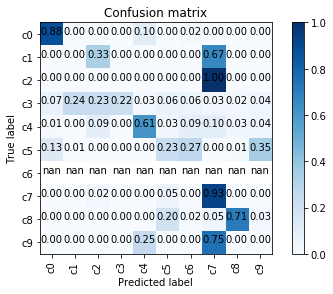

In [154]:
plot_confusion_matrix(cm, keys, normalize=True)

In [153]:
for i in range(len(keys)):
    print '{}: {}'.format(keys[i], classes[i])

c0: safe driving
c1: texting - right
c2: talking on the phone - right
c3: exting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger
